## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from Levenshtein import *
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [4]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


## Inference

In [5]:
model = keras.models.load_model("data/ncbi_02/model_gru_bi_256")
model.summary()

2021-10-07 11:04:55.089746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 11:04:55.090557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 11:04:55.102797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 11:04:55.103455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 11:04:55.104273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 512), (None, 402432      input_3[0][0]                    
__________________________________________________________________________________________________
gru_3 (GRU)                     [(None, None, 256),  201216      input_4[0][0]                    
                                                                 bidirectional_1[0][1]        

In [6]:
latent_dim = 256

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h1_enc, state_h2_enc = model.layers[2].output  # gru
encoder_model = keras.Model(encoder_inputs, [ state_h1_enc, state_h2_enc ])

encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
bidirectional_1 (Bidirection [(None, 512), (None, 256) 402432    
Total params: 402,432
Trainable params: 402,432
Non-trainable params: 0
_________________________________________________________________


In [7]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h1 = keras.Input(shape = (latent_dim, ))
decoder_states_inputs = [ decoder_state_input_h1 ]

decoder_gru = model.layers[3]
decoder_outputs, state_h1_dec = decoder_gru(
    decoder_inputs, initial_state = decoder_states_inputs
)

decoder_states = [ state_h1_dec ]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = keras.Model(
    [ decoder_inputs ] + decoder_states_inputs, [ decoder_outputs ] + decoder_states
)

decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
gru_3 (GRU)                     [(None, None, 256),  201216      input_4[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 4)      1028        gru_3[1][0]                

In [8]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [12]:
def decode_sequence(input_seq):

    output_seq = np.zeros_like(input_seq)
    
    # Encode the input as state vectors.
    state_h1, state_h2 = encoder_model.predict(input_seq)
    states_value = [ state_h1 ]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(token_index)))
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for i in range(encoder_input_data.shape[1]):
        
        output_token, state_h1 = decoder_model.predict([ target_seq ] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_token[0, -1, :])
        output_seq[0, i, sampled_token_index] = 1.0
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(token_index)))
        target_seq[0, 0, sampled_token_index] = 1.0
        
        states_value = [ state_h1 ]
        
    return output_seq

In [20]:
def decode_sequence_batch(input_seqs):
    n_seqs = input_seqs.shape[0]

    output_seqs = np.zeros_like(input_seqs)
    
    # Encode the input as state vectors.
    state_h1, state_h2 = encoder_model.predict(input_seqs)
    states_value = [ state_h1 ]
    
    # Generate empty target sequence of length 1.
    target_seqs = np.zeros((n_seqs, 1, len(token_index)))
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for i in tqdm(range(encoder_input_data.shape[1])):
        
        output_token, state_h1 = decoder_model.predict([ target_seqs ] + states_value)

        # Sample a token
        sampled_token_indexes = np.squeeze(np.argmax(output_token, axis = 2))
        output_seqs[:, i, sampled_token_indexes] = 1.0
        
        # Update the target sequence (of length 1).
        target_seqs = np.zeros((n_seqs, 1, len(token_index)))
        target_seqs[:, 0, sampled_token_indexes] = 1.0
        
        states_value = [ state_h1 ]

    return output_seqs

In [21]:
decoder_output_data = decode_sequence_batch(encoder_input_data)

with open('data/ncbi_02/predicted_gru_bi_256.npy', 'wb') as f:
    np.save(f, decoder_output_data)
    
#     d = keras.losses.CategoricalCrossentropy()(target_seq, output_seq).numpy()
#     print(f"{i}. {d}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3822/3822 [13:20<00:00,  4.77it/s]


## Metrics

In [22]:
keras.losses.CategoricalCrossentropy()(decoder_target_data, decoder_output_data).numpy()

0.009855672

In [23]:
cce = []
for i in tqdm(range(len(decoder_target_data))):
    _ = keras.losses.CategoricalCrossentropy()(decoder_target_data[i:i + 1], decoder_output_data[i:i + 1]).numpy()
    cce.append(_)
cce = np.array(cce)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4368/4368 [00:04<00:00, 926.57it/s]


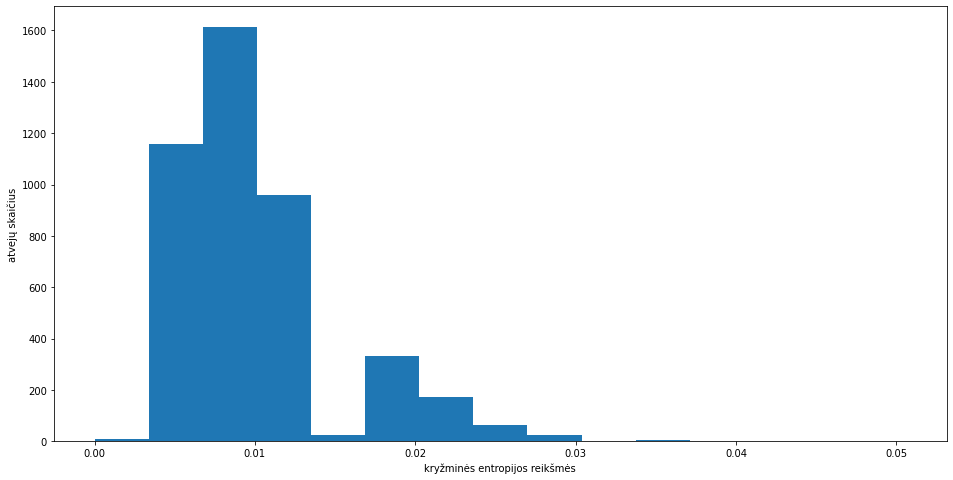

In [24]:
plt.hist(cce, bins = 15)
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.show()

In [25]:
decoder_target_sequences = decode_seq(decoder_target_data)
decoder_output_sequences = decode_seq(decoder_output_data)

```
TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAAAGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTGAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTAATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGG(A|G)TGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAACATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTACTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAA(A|T)
```

In [28]:
lev_distances = [ distance(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]
lev_ratio = [ ratio(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]
ham_distances = [ hamming(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]

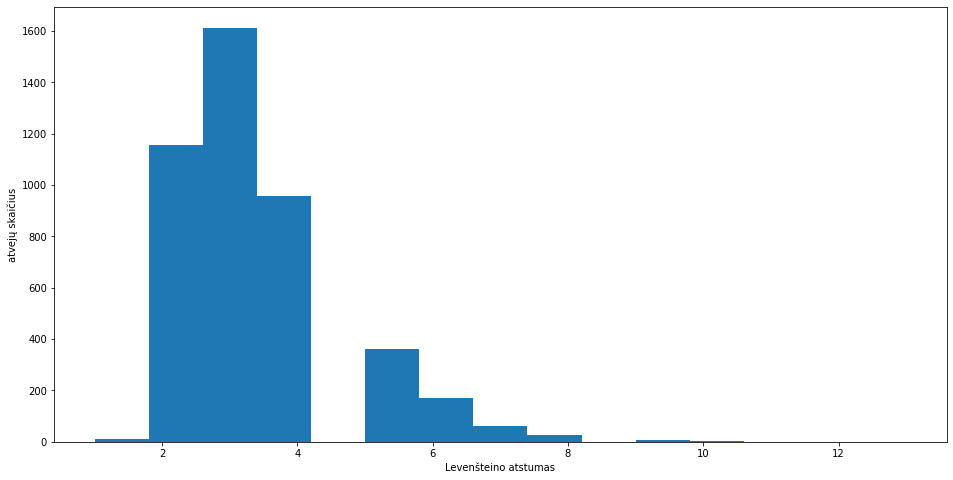

In [29]:
plt.hist(lev_distances, bins = 15)
plt.xlabel('Levenšteino atstumas')
plt.ylabel('atvejų skaičius')
plt.show()

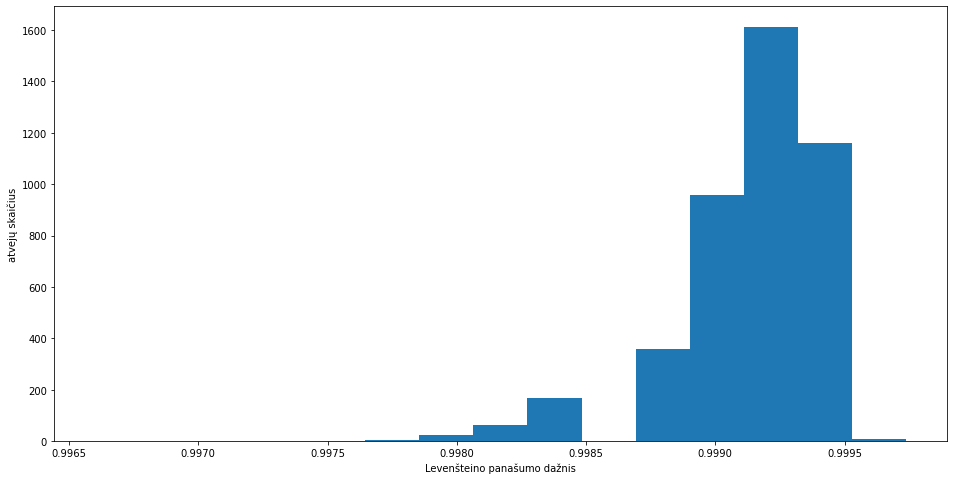

In [30]:
plt.hist(lev_ratio, bins = 15)
plt.xlabel('Levenšteino panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

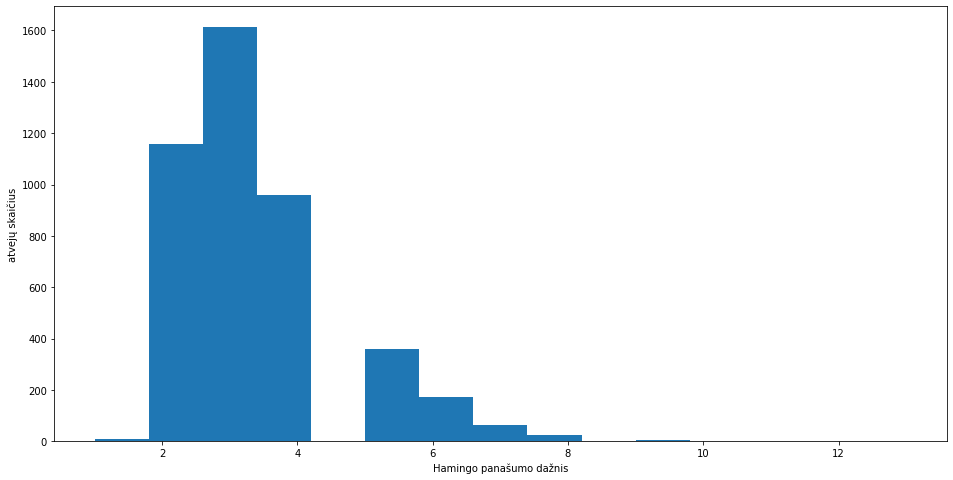

In [31]:
plt.hist(ham_distances, bins = 15)
plt.xlabel('Hamingo panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

In [32]:
mut01 = np.sum(
    (np.subtract(
        np.argmax(encoder_input_data, axis = 2), 
        np.argmax(decoder_input_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [35]:
mut02 = np.sum(
    (np.subtract(
        np.argmax(decoder_target_data, axis = 2), 
        np.argmax(decoder_output_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

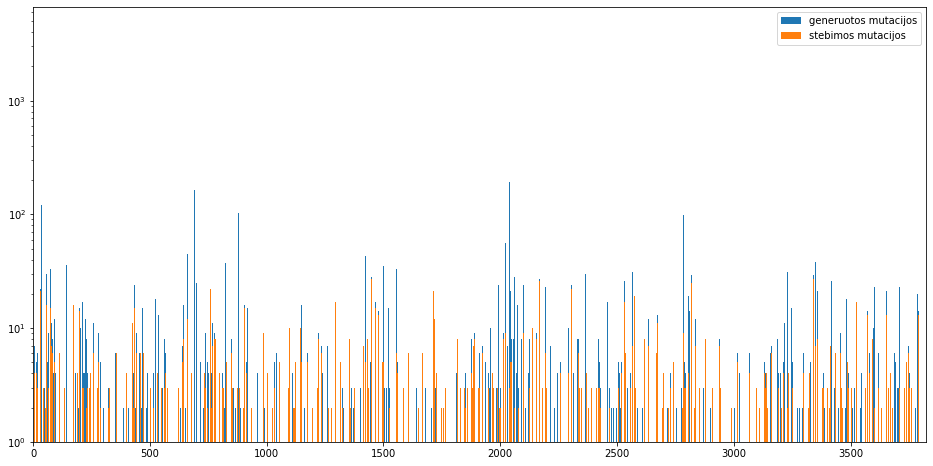

In [42]:
x_range = list(range(len(mut01)))
plt.bar(x_range, mut02, bottom = mut01, label = 'generuotos mutacijos')
plt.bar(x_range, mut01, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.yscale('log')
plt.xlim(0, len(mut01))
plt.legend()
plt.show()

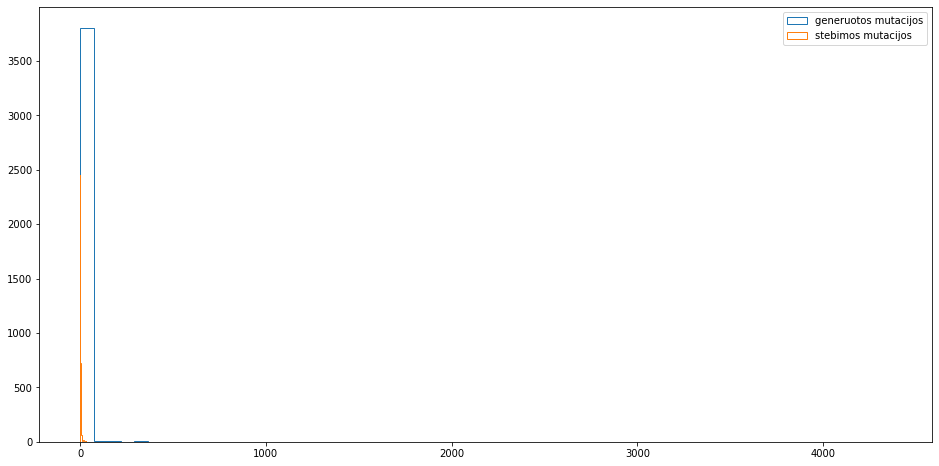

In [46]:
plt.hist(mut02, bins = 60, label = 'generuotos mutacijos', fill = False, histtype='step')
plt.hist(mut01, bins = 60, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()